# Install Packages

In [ ]:
pip install -e ./lib/quantum_electron-main/quantum_electron-main/

In [ ]:
pip install -e ./lib/zeroheliumkit_0.5.0_win/

# Imports

In [12]:
import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt

from zeroheliumkit import Structure, Rectangle, GeomCollection # type: ignore
from zeroheliumkit.src.importing import Reader_GDS,Reader_DXF,Reader_Pickle # type: ignore
from zeroheliumkit.fem import *
from zeroheliumkit.src.settings import  *
import shapely

%matplotlib inline
%config InlineBackend.figure_format='retina'

plot_config = {'wafer':BLACK,'bottom':YELLOW2,'top':(BLUE,0.6)}

# Device Importing

TransferDevice.gds // Layers in cell 'TOP': {1, 2, 3}


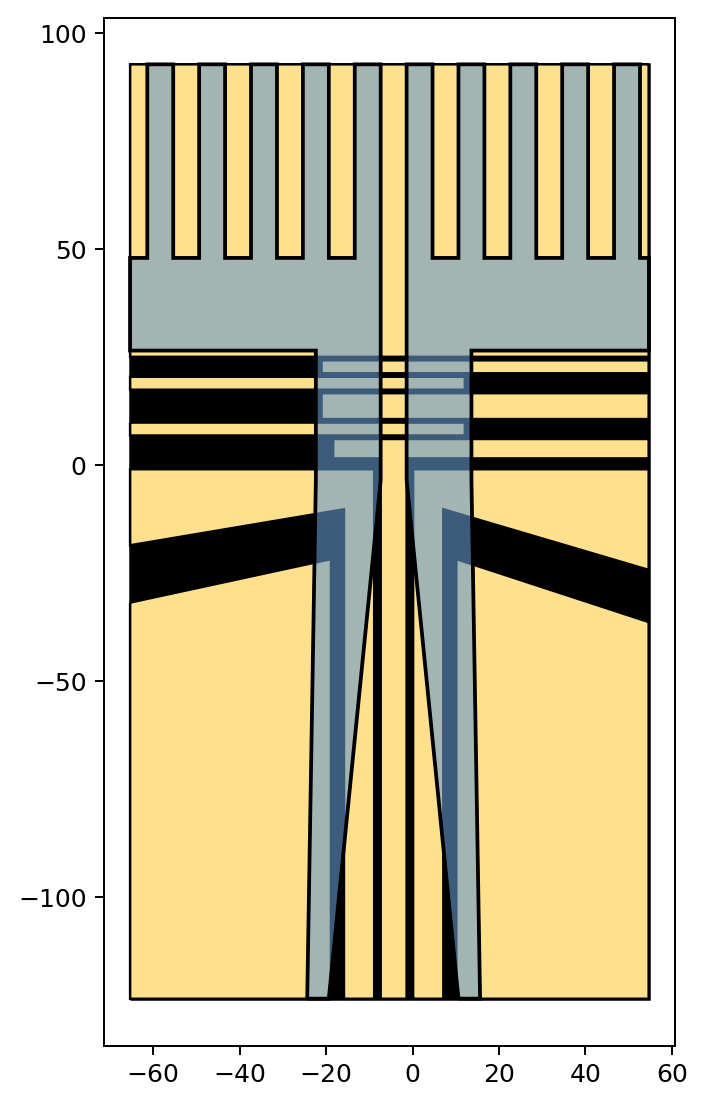

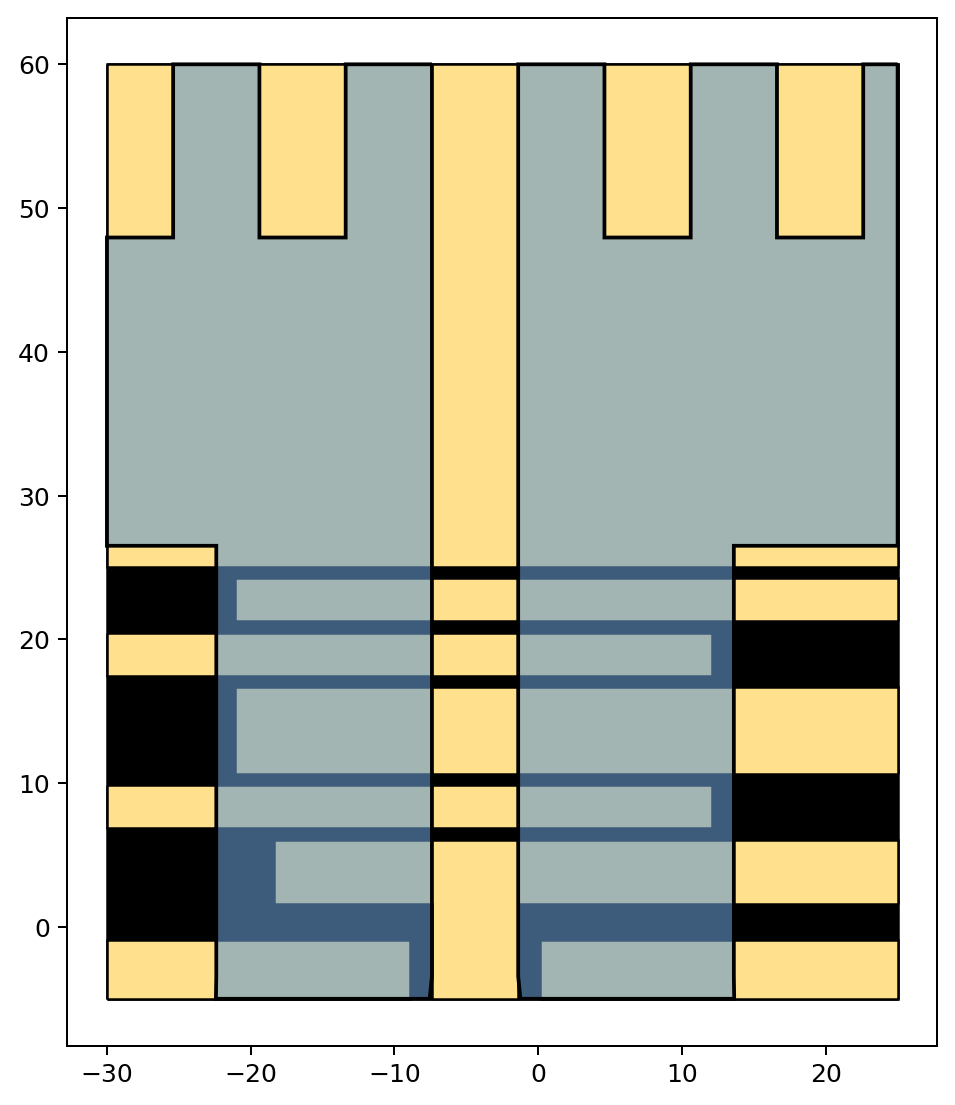

In [22]:
# Read File
file = Reader_GDS('TransferDevice.gds')
file.import2zhk("TOP")
device = GeomCollection(file.geometries)

# Rename Layers
device.rename_layer('L1','bottom')
device.rename_layer('L2','top')
device.rename_layer('L3','wafer')
device.layers

#Show Device
device.quickplot(plot_config)
plt.show()

# Cropped Version
devCrop = Structure()
devCrop.add_layer('bottom',file.geometries['L1'])
devCrop.add_layer('top',file.geometries['L2'])
devCrop.add_layer('wafer',file.geometries['L3'])
devCrop = devCrop.crop_all(shapely.box(-30,-5,25,60))  #(xmin,ymin,xmax,ymax)
devCrop.quickplot(plot_config)
plt.show()

# Viewing Electrodes

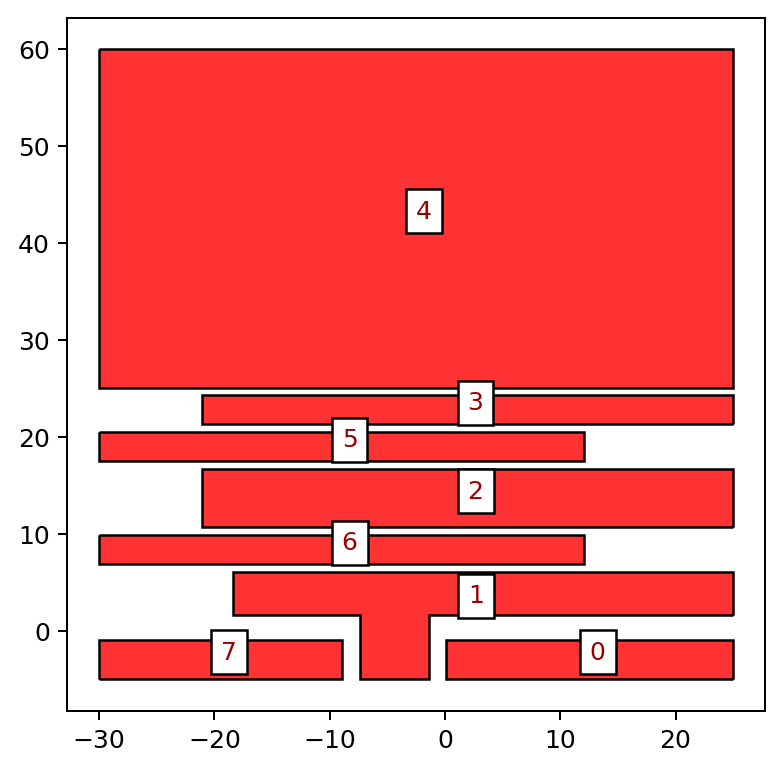

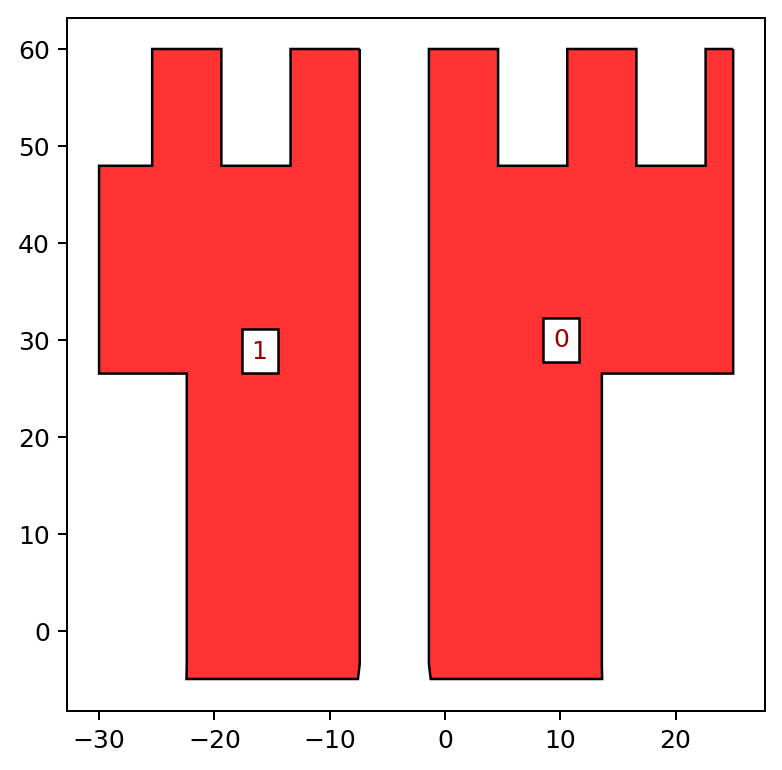

In [23]:
for layer in ["bottom","top"]:
    fig = plt.figure(1, figsize=(5,5), dpi=90)
    ax = fig.add_subplot(111)
    devCrop.plot(ax=ax, layer=[layer],color=[RED],show_idx=True)
    plt.show()

# Define 3D Geometry

In [ ]:
# defines thickness of layers [um]
d_metal1 = 0.25   # bottom metal thickness
d_metal2 = 0.25   # top metal thickness
d_diel  = 0.710
d_vac   = 25
d_He    = d_diel + d_metal2
d_total = d_metal1 + d_He

""" 
extrude_config: 
key - gmsh layer name
item - gmshLayer_info dict: 
       (geometry layer, z0, thickness, Physical Vol Name, CUT gmsh layer=None, forConstruction=False)
"""

extrude_config = {
    'wafer' :       gmshLayer_info('wafer'    , -d_vac/2 , d_vac/2         , 'DIELECTRIC'),
    'bottom':       gmshLayer_info('bottom'   , 0 , d_metal1               , 'METAL'),
    'dielectric':   gmshLayer_info('top'      , d_metal1 , d_diel          , 'DIELECTRIC'),
    'top':          gmshLayer_info('top'      , d_metal1+d_diel, d_metal2  , 'METAL'),
    'helium':       gmshLayer_info('wafer'    , d_metal1, d_He             , 'HELIUM', ('dielectric','top')),
    'vacuum':       gmshLayer_info('wafer'    , d_metal1+d_He, d_vac       , 'VACUUM', ('dielectric', 'top'))
}

""" 
electrodes_config: 
key - physicalSurface name
item - physSurface_info dict:
       (geometry layer, electrode idx in geometry layer, gmsh layer, 'linked_to'=physicalSurface name - links to specific physSurf name. Defaults 'None')
"""

electrodes_config = {
    'Barrier':      physSurface_info('bottom',   [0,7], 'bottom'),
    'ThinFilm':     physSurface_info('bottom',   [1],   'bottom'),
    'Sense':        physSurface_info('bottom',   [2],   'bottom'),
    'Door1':        physSurface_info('bottom',   [3],   'bottom'),
    'Reservoir':    physSurface_info('bottom',   [4],   'bottom'),
    'Twiddle':      physSurface_info('bottom',   [5],   'bottom'),
    'Door2':        physSurface_info('bottom',   [6],   'bottom'),
    'Top':          physSurface_info('top',      [0,1], 'top'),
}

""" 
mesh_params is a list of dicts.
Each dict is for a different density region (here fine and medium) given of the form:
Thickness : width (in um) of the transition from this region's density to the outer layers density,
VIn       : density scale inside the region
VOut      : density scale outside the region
box       : coordinates of the boundary given as [x0,x1,y0,y1,z0,z1]
"""

mediumregion_box = [-30, 25, -5, 60, -0.7, 6] #(xmin,xmax,ymin,ymax,zmin,zmax)
fineregion_box = [-10, 5, 0, 50, -0.1, 4.5]
scale = 4
mesh_params = [{"Thickness": 4, "VIn": scale * 0.4, "VOut": 1*scale, "box": mediumregion_box},
               {"Thickness": 2, "VIn": scale * 0.2, "VOut": 1*scale, "box": fineregion_box}
              ]

# Generate Mesh

In [48]:
save_dir = 'dump/'
mshID = 'TransferDevice'
meshMKR =  GMSHmaker(layout=devCrop, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_params)
meshMKR.create_geo(save_dir+mshID )
meshMKR.create_mesh(save_dir+mshID, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 2.6s (0.38/s)                              


# Create edp file

In [49]:
He_level = round(d_total,3)

var_eps = {
        'DIELECTRIC': 11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

ff_config ={
    'meshfile': save_dir+mshID,
    'dielectric_constants': var_eps,
    'ff_polynomial': 2,
    'extract_opt': [extract_results('phi', 'xy', (-10, 5,1001), (0, 50,201), He_level,'TransferDevice'),
                    ],
    'physicalSurfaces': {k: v.get('group_id') for (k, v) in meshMKR.physicalSurfaces.items()},
    'physicalVolumes': {k: v.get('group_id') for (k, v) in meshMKR.physicalVolumes.items()}
}

with open(save_dir+r'config.yaml', 'w') as file:
    documents = yaml.safe_dump(ff_config, file)

In [50]:
with open(save_dir+r'config.yaml', 'r') as file:
    config = yaml.safe_load(file)

yff = FreeFEM(config=config,
               dirname='./',
               run_from_notebook=False)

In [ ]:
# View -> Terminal, or Ctrl+`
cd C:\Users\LyonLab\Documents\GitHub\LyonLabCodebase\femSims\Tiffany\ThinFilmTransportNew
freefem++ ./dump/TransferDevice.edp